In [369]:
"""
Apply k-means clustering to keywords that have been output by Google Search Console, and output aggregate data as csv
You could use this e.g. for identifying SEO shortcomings, or to inform your paid search strategy

Most helpful article I found was http://brandonrose.org/clustering

This example uses data from the Google Data Studio sample data source
To extend/adapt, simply change the column names

Can be used in tandem with https://docs.google.com/spreadsheets/d/1PEvao-44P4Bdrl4ZjdbqMDjlW0EkQlOPN_qSVF4Kzis/edit?usp=sharing

@author: Sam Alexander
"""

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt

import csv

KEYWORDS_FILENAME = 'gsc-sample.csv'
KEYWORDS_FIELD = 'Query'
BRAND_KEYWORDS = 'google|you tube|youtube|yt|android|chrome'

In [370]:
# Load keywords that you want to cluster, plus any accompanying attributes
df = pd.read_csv(KEYWORDS_FILENAME)
df = df[~df[KEYWORDS_FIELD].str.contains(BRAND_KEYWORDS)]
df.tail(5)

,Query,Clicks,Impressions,Site CTR,Average Position
1040,go merchandise,1,37,2.7%,2.5
1045,t-shirt apparel,1,10,10.0%,8.5
1049,tube shop,1,4,25.0%,7.8
1051,gsoc t shirt 2019,1,3,33.3%,6.7
1052,hoodie shopping,1,5,20.0%,36.2


In [371]:
# Transform the queries into a matrix of tf-idf vectors
# Could also try stemming/lemmatisation here    
documents = df[KEYWORDS_FIELD].tolist()
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

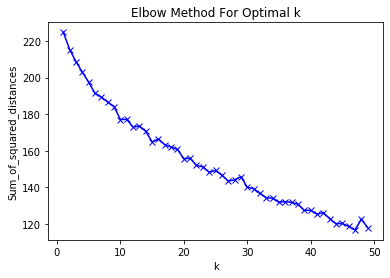

In [372]:
# Use an elbow plot to estimate the best value to choose for 'k'
def elbow_plot(upper_k, max_iter, n_init):
    Sum_of_squared_distances = []
    K = range(1,upper_k)
    for k in K:
        model = KMeans(n_clusters=k, init='k-means++', max_iter=max_iter, n_init=n_init)
        model.fit(X)
        Sum_of_squared_distances.append(model.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
elbow_plot(upper_k=50, max_iter=500, n_init=5)

In [373]:
# Select 'k' value from where the plot appears to bend/flatten, and use to fit model
true_k = 20
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=10000, n_init=100)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=20, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [374]:
# Create new dataframe from original csv data, using the new cluster values as the index
clusters = model.labels_.tolist()
docs = {'cluster': clusters,
        'query': documents, 
        'clicks': df['Clicks'].tolist(), 
        'impressions': df['Impressions'].tolist(), 
        'ctr': df['Site CTR'].tolist(), 
        'position': df['Average Position'].tolist()}
frame = pd.DataFrame(docs)
frame.set_index('cluster', inplace=True)
frame

,query,clicks,impressions,ctr,position
cluster,,,,,
17,jazzybum merch,778,1896,41.0%,1.2
19,jazzybum merchandise,124,285,43.5%,1.0
18,구글 머천다이즈,33,49,67.3%,1.0
2,apparel store,22,1409,1.6%,4.4
4,flutter t shirt,18,97,18.6%,3.5
...,...,...,...,...,...
19,go merchandise,1,37,2.7%,2.5
2,t-shirt apparel,1,10,10.0%,8.5
10,tube shop,1,4,25.0%,7.8


In [375]:
# Print each cluster (truncate for large datasets)
def print_clusters(clusters_df=None):
    for ix in np.sort(clusters_df.index.unique()):
        print('Cluster %d:' % ix)
        if hasattr(clusters_df.loc[ix]['query'],'values'):
            for query in clusters_df.loc[ix]['query'].values.tolist():
                print(' %s\n' % query, end='')
        else:
            print(' %s\n' % clusters_df.loc[ix]['query'], end='')
        print('\n')
        
print_clusters(frame)

Cluster 0:
 pixelbook return policy
 nest return policy
 tee white
 does world market ship to canada
 pixel 4 shipping time
 does wish deliver to po boxes
 tee coral
 world market ship to canada
 does wish ship to apo
 grey pullover
 does wish ship to po box


Cluster 1:
 cloud merchandise
 cloud swag


Cluster 2:
 apparel store
 apparel shop
 shop apparel
 apparel stores
 store apparel
 apparel for babies
 apparel-store
 the apparel store
 apparel orders
 apparel
 t shirt apparel
 t-shirt apparel


Cluster 3:
 dvg merchandise
 dvg merch
 dvg family merch
 dvg fam hoodie
 dvg fam.shop
 dvg fam shop
 dvg fam merch


Cluster 4:
 flutter t shirt
 flutter shirt
 tensorflow shirt
 gcp t shirt
 tensorflow t shirt india
 gcp t-shirt
 tensorflow t shirt
 flutter t-shirt
 flutter t shirt free
 firebase shirt
 free gcp t-shirt
 firebase t shirt
 tensorflow t-shirt
 local guide t shirt
 golang t shirt
 angular t shirt
 merchandise t shirt
 t shirt merchandising
 gsoc t shirt 2019


Cluster 5:
 ki

In [376]:
# Could optionally combine clusters that appear to overlap here as a separate step

In [378]:
# Does one cluster stand out as over-sized? If so, repeat-cluster just the keywords in this cluster
# (Otherwise skip to the end and output as csv)
# Repeat as necessary
repeat_cluster = 10

# Take largest cluster and cluster again, to see if this can be broken down
documents_2 = frame.loc[repeat_cluster]['query'].values.tolist()
X_2 = vectorizer.fit_transform(documents_2)

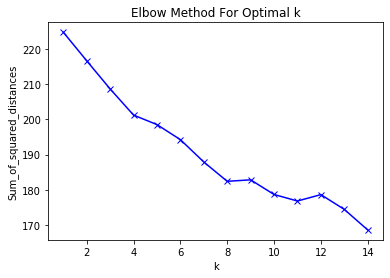

In [379]:
# Use an elbow plot to estimate the best value to choose for 'k'
elbow_plot(upper_k=15, max_iter=500, n_init=5)

In [380]:
# Select 'k' value from where the plot appears to bend/flatten, and use to fit model
true_k_2 = 8
model_2 = KMeans(n_clusters=true_k_2, init='k-means++', max_iter=10000, n_init=100)
model_2.fit(X_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=8, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [381]:
# Create new dataframe from original csv data, using the new cluster values as the index
clusters_2 = model_2.labels_.tolist()
docs_2 = {'cluster': clusters_2,
        'query': documents_2, 
        'clicks': frame.loc[repeat_cluster]['clicks'].tolist(), 
        'impressions': frame.loc[repeat_cluster]['impressions'].tolist(), 
        'ctr': frame.loc[repeat_cluster]['ctr'].tolist(), 
        'position': frame.loc[repeat_cluster]['position'].tolist()}
frame_2 = pd.DataFrame(docs_2)
frame_2.set_index('cluster', inplace=True)
frame_2

,query,clicks,impressions,ctr,position
cluster,,,,,
0,구글머천다이즈,14,17,82.4%,1.0
0,구글머천다이즈스토어,11,15,73.3%,1.0
7,shop by brand,10,362,2.8%,3.2
0,thermal bottle,9,2302,0.4%,9.2
5,g_enabled_idps,9,125,7.2%,2.9
0,гугл мерч,6,45,13.3%,3.0
4,black tee,5,3384,0.1%,3.5
0,warm gear,5,458,1.1%,10.7
6,gcp swag,4,19,21.1%,5.2


In [382]:
# Print each cluster
print_clusters(frame_2)

Cluster 0:
 구글머천다이즈
 구글머천다이즈스토어
 thermal bottle
 гугл мерч
 warm gear
 グーグルマーチャンダイズストア
 mouse pad
 morebags
 puzzlebot
 bugdroid toy
 यूट्यूब स्टोर
 noogler
 enjoy mug
 متجر يوتيوب
 red yutube
 yuotube.com ph
 will be shipped within
 shopby
 गूगल पैड
 dinosaur game
 اندرويد شوب
 tou.tube
 robertsonmarketing
 campus bike
 bamboo holder
 logo ggo
 2pack
 lapel pin
 shrome://dino
 notebook set
 グーグル tシャツ
 crome dinosour
 campus collection
 stickers


Cluster 1:
 _dc_gtm cookie


Cluster 2:
 jutjub shop
 goigle shop
 apo shop
 figure shop
 tube shop


Cluster 3:
 utility backpacks
 utility backpack


Cluster 4:
 black tee
 black sherpa vest
 red tee
 tee black


Cluster 5:
 g_enabled_idps
 g_enabled_idps cookie


Cluster 6:
 gcp swag
 gcp swags


Cluster 7:
 shop by brand
 by brand




In [383]:
# Rename clusters for these new sub-clusters to fit the main results dataframe
for ix in np.sort(frame_2.index.unique()):
    frame_2.rename({ix: true_k+ix}, inplace=True)
frame_2.head(5)

,query,clicks,impressions,ctr,position
cluster,,,,,
20,구글머천다이즈,14,17,82.4%,1.0
20,구글머천다이즈스토어,11,15,73.3%,1.0
27,shop by brand,10,362,2.8%,3.2
20,thermal bottle,9,2302,0.4%,9.2
25,g_enabled_idps,9,125,7.2%,2.9


In [384]:
# Drop the cluster that we have broken down, and instead rename the last cluster to this
frame.drop(labels=[repeat_cluster], inplace=True)
frame_2.rename({frame_2.index.unique().max(): repeat_cluster}, inplace=True)

# Combine both cluster dataframes
final = frame.append(frame_2)
final

,query,clicks,impressions,ctr,position
cluster,,,,,
17,jazzybum merch,778,1896,41.0%,1.2
19,jazzybum merchandise,124,285,43.5%,1.0
18,구글 머천다이즈,33,49,67.3%,1.0
2,apparel store,22,1409,1.6%,4.4
4,flutter t shirt,18,97,18.6%,3.5
...,...,...,...,...,...
21,_dc_gtm cookie,1,7,14.3%,9.6
24,red tee,1,451,0.2%,3.9
23,utility backpack,1,1156,0.1%,1.7


In [385]:
# Print all clusters
print_clusters(final)

Cluster 0:
 pixelbook return policy
 nest return policy
 tee white
 does world market ship to canada
 pixel 4 shipping time
 does wish deliver to po boxes
 tee coral
 world market ship to canada
 does wish ship to apo
 grey pullover
 does wish ship to po box


Cluster 1:
 cloud merchandise
 cloud swag


Cluster 2:
 apparel store
 apparel shop
 shop apparel
 apparel stores
 store apparel
 apparel for babies
 apparel-store
 the apparel store
 apparel orders
 apparel
 t shirt apparel
 t-shirt apparel


Cluster 3:
 dvg merchandise
 dvg merch
 dvg family merch
 dvg fam hoodie
 dvg fam.shop
 dvg fam shop
 dvg fam merch


Cluster 4:
 flutter t shirt
 flutter shirt
 tensorflow shirt
 gcp t shirt
 tensorflow t shirt india
 gcp t-shirt
 tensorflow t shirt
 flutter t-shirt
 flutter t shirt free
 firebase shirt
 free gcp t-shirt
 firebase t shirt
 tensorflow t-shirt
 local guide t shirt
 golang t shirt
 angular t shirt
 merchandise t shirt
 t shirt merchandising
 gsoc t shirt 2019


Cluster 5:
 ki

In [386]:
# Sort dataframe and output csv
final.sort_index(inplace=True)
header = ['query', 'clicks', 'impressions', 'ctr', 'position']
final.to_csv('Search Console Clustered Keywords.csv', columns = header)